In [ ]:
# This is a new notebook for user segmentation.
# Please copy the code from the chat to load data from MongoDB into this cell.
# --- Connect to MongoDB ---
import pandas as pd
from pymongo import MongoClient

client = MongoClient('mongodb://localhost:27017/')
db = client['recsys_db']
reviews_collection = db['Clothing_Shoes_and_Jewelry']
# --- Connect to MongoDB ---
import pandas as pd
from pymongo import MongoClient

client = MongoClient('mongodb://localhost:27017/')
db = client['recsys_db']
reviews_collection = db['Clothing_Shoes_and_Jewelry']

# --- Fetch a random sample of 100,000 reviews ---
print("Fetching a random sample of 100,000 reviews...")
pipeline = [
    { '$sample': { 'size': 100000 } }
]

cursor = reviews_collection.aggregate(pipeline, allowDiskUse=True)

# --- Load in chunks to avoid high memory usage ---
batch_size = 10000
batches = []
batch = []

for i, doc in enumerate(cursor, start=1):
    batch.append(doc)
    if i % batch_size == 0:
        batches.append(pd.DataFrame(batch))
        print(f"Loaded {i} documents so far...")
        batch = []

# Add the last batch
if batch:
    batches.append(pd.DataFrame(batch))

# --- Concatenate all batches into one DataFrame ---
reviews_df = pd.concat(batches, ignore_index=True)

print(f"✅ Successfully loaded {len(reviews_df)} reviews into a DataFrame.")

# --- Display the first few rows and info ---
print("\nDataFrame Info:")
reviews_df.info()

print("\nDataFrame Head:")
print(reviews_df.head())
# --- Fetch a random sample of 100,000 reviews ---
print("Fetching a random sample of 100,000 reviews...")
pipeline = [
    { '$sample': { 'size': 100000 } }
]

cursor = reviews_collection.aggregate(pipeline, allowDiskUse=True)

# --- Load in chunks to avoid high memory usage ---
batch_size = 10000
batches = []
batch = []

for i, doc in enumerate(cursor, start=1):
    batch.append(doc)
    if i % batch_size == 0:
        batches.append(pd.DataFrame(batch))
        print(f"Loaded {i} documents so far...")
        batch = []

# Add the last batch
if batch:
    batches.append(pd.DataFrame(batch))

# --- Concatenate all batches into one DataFrame ---
reviews_df = pd.concat(batches, ignore_index=True)

print(f"✅ Successfully loaded {len(reviews_df)} reviews into a DataFrame.")

# --- Display the first few rows and info ---
print("\nDataFrame Info:")
reviews_df.info()

print("\nDataFrame Head:")
print(reviews_df.head())

In [2]:
# --- Create User Features ---

# Group by user_id and aggregate to create features
user_df = reviews_df.groupby('user_id').agg(
    n_reviews=('rating', 'count'),
    mean_rating=('rating', 'mean')
).reset_index()

# --- Display the new user DataFrame ---
print("✅ Successfully created user features.")# --- Create User Features ---

# Group by user_id and aggregate to create features
user_df = reviews_df.groupby('user_id').agg(
    n_reviews=('rating', 'count'),
    mean_rating=('rating', 'mean')
).reset_index()

# --- Display the new user DataFrame ---
print("✅ Successfully created user features.")

print("\nUser DataFrame Info:")
user_df.info()

print("\nUser DataFrame Head:")
print(user_df.head())


print("\nUser DataFrame Info:")
user_df.info()

print("\nUser DataFrame Head:")
print(user_df.head())


✅ Successfully created user features.
✅ Successfully created user features.

User DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98296 entries, 0 to 98295
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   user_id      98296 non-null  object 
 1   n_reviews    98296 non-null  int64  
 2   mean_rating  98296 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.2+ MB

User DataFrame Head:
                        user_id  n_reviews  mean_rating
0  AE223RESKPXP7FRTRFDE3MKUFICQ          1          3.0
1  AE225CCR5VZ4V5F7RDYWATMJ35TA          1          5.0
2  AE227TRWV65DG46TR4E5HPIO5MPQ          1          5.0
3  AE22BGVNV4GOGWMJS5DPYQ4S7TSQ          1          5.0
4  AE22CED3SGS34WKRMEHSSDD6VMWQ          1          5.0

User DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98296 entries, 0 to 98295
Data columns (total 3 columns):
 #   Column       Non-Null Count  

In [3]:
print(reviews_df.columns.tolist())

['_id', 'rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase']


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# -----------------------------
# 1. Extended User Feature Engineering
# -----------------------------
# Assume reviews_df is already loaded from MongoDB
# Columns: ['_id', 'rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase']

# Create review length feature
reviews_df['review_length'] = reviews_df['text'].fillna("").str.len()

# Aggregate user-level features
user_df = reviews_df.groupby('user_id').agg(
    num_reviews=('rating', 'count'),
    avg_rating=('rating', 'mean'),
    std_rating=('rating', 'std'),
    min_rating=('rating', 'min'),
    max_rating=('rating', 'max'),
    avg_review_length=('review_length', 'mean'),
    num_verified_reviews=('verified_purchase', 'sum'),
    avg_helpful_vote=('helpful_vote', 'mean')
).reset_index()

# Fill NaN for std_rating (users with only 1 review)
user_df['std_rating'] = user_df['std_rating'].fillna(0)

print("✅ Successfully created extended user features")
print(user_df.info())
print(user_df.sample(5))

# -----------------------------
# 2. Feature Scaling
# -----------------------------
features = ['num_reviews', 'avg_rating', 'std_rating', 'min_rating', 'max_rating',
            'avg_review_length', 'num_verified_reviews', 'avg_helpful_vote']

scaler = StandardScaler()
scaled_features = scaler.fit_transform(user_df[features])

# -----------------------------
# 3. Find optimal number of clusters
# -----------------------------
distortions = []
silhouette_scores = []
K = range(2, 11)  # test k=2..10

print("\nTesting different values of k for clustering...")
for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(scaled_features)
    distortions.append(km.inertia_)
    silhouette_scores.append(silhouette_score(scaled_features, labels))
    print(f"k={k}: inertia={km.inertia_:.2f}, silhouette={silhouette_scores[-1]:.3f}")

# Plot Elbow and Silhouette Score
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(K, distortions, marker='o')
plt.xlabel('k')
plt.ylabel('Inertia (distortion)')
plt.title('Elbow Method')

plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, marker='o')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')

plt.tight_layout()
plt.show()

# -----------------------------
# 4. Run K-Means with best k
# -----------------------------
best_k = K[silhouette_scores.index(max(silhouette_scores))]
print(f"\n✅ Best k based on silhouette score: {best_k}")

kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
user_df['cluster'] = kmeans.fit_predict(scaled_features)

# -----------------------------
# 5. Display results
# -----------------------------
print(f"\n✅ Successfully clustered users into {best_k} groups.")
print("\nCluster distribution:")
print(user_df['cluster'].value_counts())

print("\nSample user clusters:")
print(user_df.sample(10))


✅ Successfully created extended user features
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98296 entries, 0 to 98295
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   user_id               98296 non-null  object 
 1   num_reviews           98296 non-null  int64  
 2   avg_rating            98296 non-null  float64
 3   std_rating            98296 non-null  float64
 4   min_rating            98296 non-null  float64
 5   max_rating            98296 non-null  float64
 6   avg_review_length     98296 non-null  float64
 7   num_verified_reviews  98296 non-null  int64  
 8   avg_helpful_vote      98296 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 6.7+ MB
None
                            user_id  num_reviews  avg_rating  std_rating  \
50796  AG3VRLNMDHP3KXKWFNBXVW7HETPA            1         5.0         0.0   
97359  AHYUAGOIHU5TCMFCZTNNO2FZMRRA            1         1.0      

✅ User features created.
                            user_id  num_reviews  avg_rating  std_rating  \
23507  AEYLUK3YV7QQZRU7IOJQTXEELI6A            1         1.0         0.0   
28538  AF72PEBSZRTPGJX56EHTMTW5IUJA            1         5.0         0.0   
5887   AEBUJSCBYIO2CIPRTQVDPSDPDQPQ            1         1.0         0.0   
3537   AE6Q2XTLHDN4Z7Z6TVT5JNNGPSVQ            1         1.0         0.0   
54379  AGAKZR4GVZB7TTGC6TH7WXVOAS5A            1         5.0         0.0   

       min_rating  max_rating  avg_review_length  num_verified_reviews  \
23507         1.0         1.0              100.0                     1   
28538         5.0         5.0              238.0                     1   
5887          1.0         1.0              298.0                     1   
3537          1.0         1.0              187.0                     1   
54379         5.0         5.0              100.0                     1   

       avg_helpful_vote  
23507               0.0  
28538               0

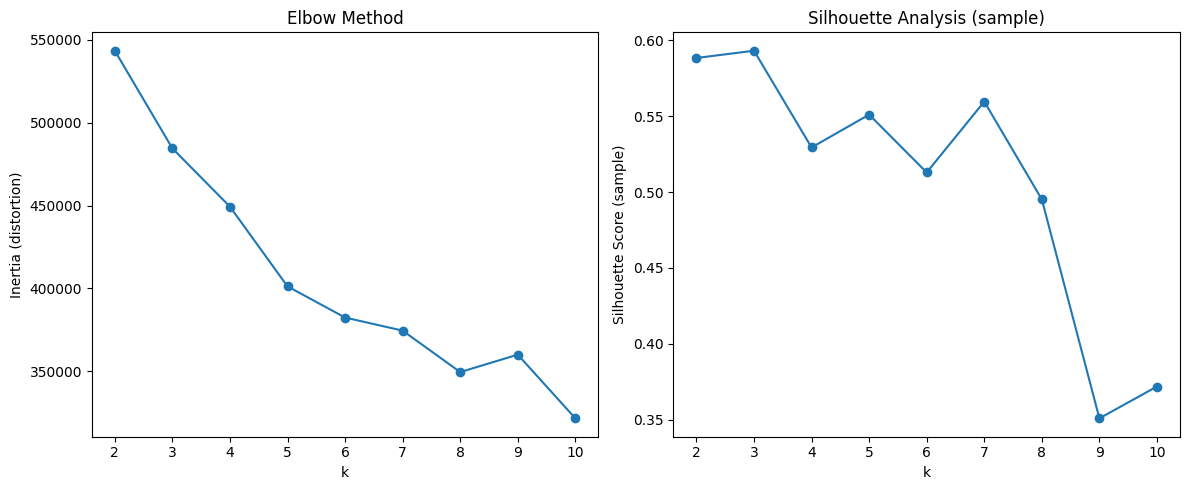


✅ Best k based on silhouette score (sample): 3

✅ Successfully clustered users into 3 groups.

Cluster distribution:
cluster
0    65762
2    21363
1    11171
Name: count, dtype: int64


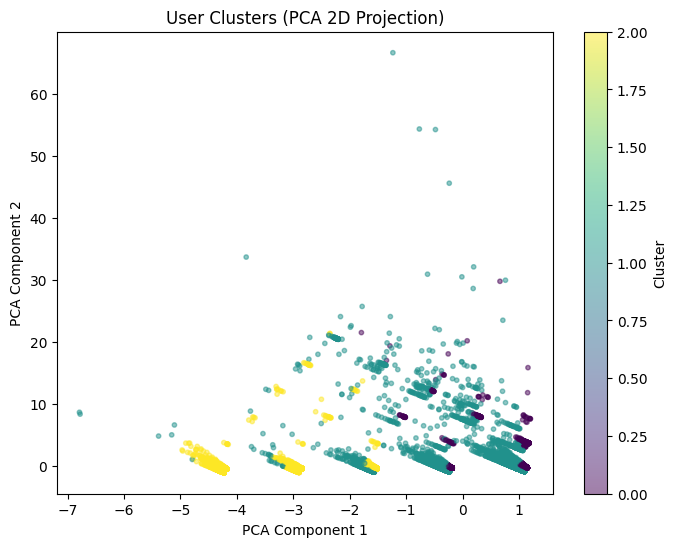

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# -----------------------------
# 1. Extended User Feature Engineering
# -----------------------------
reviews_df['review_length'] = reviews_df['text'].fillna("").str.len()

user_df = reviews_df.groupby('user_id').agg(
    num_reviews=('rating', 'count'),
    avg_rating=('rating', 'mean'),
    std_rating=('rating', 'std'),
    min_rating=('rating', 'min'),
    max_rating=('rating', 'max'),
    avg_review_length=('review_length', 'mean'),
    num_verified_reviews=('verified_purchase', 'sum'),
    avg_helpful_vote=('helpful_vote', 'mean')
).reset_index()

user_df['std_rating'] = user_df['std_rating'].fillna(0)

print("✅ User features created.")
print(user_df.sample(5))

# -----------------------------
# 2. Feature Scaling
# -----------------------------
features = ['num_reviews', 'avg_rating', 'std_rating', 'min_rating', 'max_rating',
            'avg_review_length', 'num_verified_reviews', 'avg_helpful_vote']

scaler = StandardScaler()
scaled_features = scaler.fit_transform(user_df[features])

# -----------------------------
# 3. Find optimal number of clusters (Elbow + silhouette on sample)
# -----------------------------
distortions = []
silhouette_scores = []
K = range(2, 11)

sample_size = 5000
sample_idx = np.random.choice(len(scaled_features), size=sample_size, replace=False)
sample_features = scaled_features[sample_idx]

print("\nTesting different values of k...")
for k in K:
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=5000)
    labels_full = kmeans.fit_predict(scaled_features)
    
    # Silhouette on sample only
    labels_sample = labels_full[sample_idx]
    silhouette = silhouette_score(sample_features, labels_sample)
    
    distortions.append(kmeans.inertia_)
    silhouette_scores.append(silhouette)
    print(f"k={k}: inertia={kmeans.inertia_:.2f}, silhouette={silhouette:.3f}")

# Plot Elbow and Silhouette
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(K, distortions, marker='o')
plt.xlabel('k')
plt.ylabel('Inertia (distortion)')
plt.title('Elbow Method')

plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, marker='o')
plt.xlabel('k')
plt.ylabel('Silhouette Score (sample)')
plt.title('Silhouette Analysis (sample)')

plt.tight_layout()
plt.show()

# -----------------------------
# 4. Final clustering with best k
# -----------------------------
best_k = K[silhouette_scores.index(max(silhouette_scores))]
print(f"\n✅ Best k based on silhouette score (sample): {best_k}")

final_kmeans = MiniBatchKMeans(n_clusters=best_k, random_state=42, batch_size=5000)
user_df['cluster'] = final_kmeans.fit_predict(scaled_features)

print(f"\n✅ Successfully clustered users into {best_k} groups.")
print("\nCluster distribution:")
print(user_df['cluster'].value_counts())

# -----------------------------
# 5. PCA 2D visualization
# -----------------------------
pca = PCA(n_components=2, random_state=42)
pca_features = pca.fit_transform(scaled_features)

plt.figure(figsize=(8,6))
plt.scatter(pca_features[:,0], pca_features[:,1], c=user_df['cluster'], cmap='viridis', alpha=0.5, s=10)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('User Clusters (PCA 2D Projection)')
plt.colorbar(label='Cluster')
plt.show()



In [8]:
# --- Merge cluster labels back with the original reviews ---
reviews_with_clusters_df = pd.merge(
    reviews_df, 
    user_df[['user_id', 'cluster']], 
    on='user_id'
)

print("Successfully merged cluster labels with reviews.")

# --- Generate Recommendations for Each Cluster ---
# For each cluster, we'll find the items with the highest number of reviews and the best average rating.
cluster_recommendations = reviews_with_clusters_df.groupby(['cluster', 'asin']).agg(
    n_reviews_in_cluster=('rating', 'count'),
    mean_rating_in_cluster=('rating', 'mean')
).reset_index()

# --- Sort to find the top items per cluster ---
cluster_recommendations.sort_values(
    by=['cluster', 'n_reviews_in_cluster', 'mean_rating_in_cluster'],
    ascending=[True, False, False],
    inplace=True
)

# --- Display the top 5 recommended items for each cluster ---
print("\n--- Top 5 Recommendations per Cluster ---")
for i in range(k):  # k is the number of clusters you found
    print(f"\n--- Cluster {i} ---")
    top_items = cluster_recommendations[cluster_recommendations['cluster'] == i].head(5)
    print(top_items)

Successfully merged cluster labels with reviews.

--- Top 5 Recommendations per Cluster ---

--- Cluster 0 ---
       cluster        asin  n_reviews_in_cluster  mean_rating_in_cluster
4502         0  B004QF0TFQ                    12                4.833333
14133        0  B00NW62PCA                    10                4.900000
2630         0  B002G9UDYG                     9                5.000000
3981         0  B00459VM6I                     9                4.888889
39057        0  B07FPVR858                     9                4.888889

--- Cluster 1 ---
       cluster        asin  n_reviews_in_cluster  mean_rating_in_cluster
63883        1  B000JQFX1G                     4                4.750000
66793        1  B00V6GSLW6                     3                5.000000
65364        1  B009KYJAJY                     3                4.666667
67396        1  B018HTGSN8                     3                4.666667
63714        1  B0006AAS4M                     3                4.3

In [9]:
# --- Analyze the characteristics of each cluster ---
# Group by cluster and calculate the mean of the features for each group
cluster_analysis = user_df.groupby('cluster')[features].mean()
print("--- Average Feature Values per Cluster ---")
print(cluster_analysis)


--- Average Feature Values per Cluster ---
         num_reviews  avg_rating  std_rating  min_rating  max_rating  \
cluster                                                                
0           1.008850    4.840830    0.002520    4.838950    4.842629   
1           1.093277    4.549178    0.050331    4.508817    4.585713   
2           1.003745    1.956209    0.003501    1.953752    1.958807   

         avg_review_length  num_verified_reviews  avg_helpful_vote  
cluster                                                             
0                98.764579              1.008546          0.311650  
1               468.533706              0.536747          3.326168  
2               164.467631              0.964190          0.702398  


In [17]:
# --- 1. Load Product Metadata (Corrected) ---
meta_collection = db['meta_Clothing_Shoes_and_Jewelry']

# Get the unique PARENT ASINs from our reviews sample
parent_asins_in_sample = reviews_df['parent_asin'].unique().tolist()

# Fetch the metadata using the 'parent_asin' field
print(f"Fetching metadata for {len(parent_asins_in_sample)} unique parent products...")
meta_docs = list(meta_collection.find({'parent_asin': { '$in': parent_asins_in_sample } }))

# Convert to DataFrame
meta_df = pd.DataFrame(meta_docs)

print(f"Successfully loaded metadata for {len(meta_df)} products.")

# --- 2. Merge Reviews with Metadata (Corrected) ---
# We now merge on the 'parent_asin' column, which exists in both DataFrames
if not meta_df.empty:
    print("\nMerging reviews with product metadata on 'parent_asin'...")
    merged_df = pd.merge(
        reviews_df,
        meta_df,
        on='parent_asin', # Use the common column to join
        how='inner',
        suffixes=('_review', '_meta') # Add suffixes to distinguish overlapping columns like 'title'
    )

    print("\n✅ Successfully merged reviews with product metadata.")
    print("\nMerged DataFrame Info:")
    merged_df.info()

    print("\nMerged DataFrame Head:")
    print(merged_df.head())
else:
    print("\nCould not perform merge because no matching metadata was found.")



Fetching metadata for 75264 unique parent products...
Successfully loaded metadata for 75264 products.

Merging reviews with product metadata on 'parent_asin'...

✅ Successfully merged reviews with product metadata.

Merged DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   _id_review         100000 non-null  object 
 1   rating             100000 non-null  float64
 2   title_review       100000 non-null  object 
 3   text               100000 non-null  object 
 4   images_review      100000 non-null  object 
 5   asin               100000 non-null  object 
 6   parent_asin        100000 non-null  object 
 7   user_id            100000 non-null  object 
 8   timestamp          100000 non-null  int64  
 9   helpful_vote       100000 non-null  int64  
 10  verified_purchase  100000 non-null  bool   
 11  review_l

In [16]:
import json
meta_collection = db['meta_Clothing_Shoes_and_Jewelry']

print("--- One Sample Metadata Document ---")
one_meta_doc = meta_collection.find_one()

# Print it in a nicely formatted way
if one_meta_doc:
    print("---Field names:---")
    print(list(one_meta_doc.keys()))
else:
     print("Could not retrieve a document from the metadata collection.")

--- One Sample Metadata Document ---
---Field names:---
['_id', 'main_category', 'title', 'average_rating', 'rating_number', 'features', 'description', 'price', 'images', 'videos', 'store', 'categories', 'details', 'parent_asin', 'bought_together']
